In [6]:
import sys
import os
sys.path.append("./Grounded_Segment_Anything/recognize-anything")
sys.path.append("./Grounded_Segment_Anything/GroundingDINO")
sys.path.append("./Grounded_Segment_Anything/segment_anything")

import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
# import pykinect_azure as pykinect
import open3d as o3d

# Grounding DINO
import Grounded_Segment_Anything.GroundingDINO.groundingdino.datasets.transforms as T
from Grounded_Segment_Anything.GroundingDINO.groundingdino.models import build_model
from Grounded_Segment_Anything.GroundingDINO.groundingdino.util.slconfig import SLConfig
from Grounded_Segment_Anything.GroundingDINO.groundingdino.util.utils import (
    clean_state_dict, 
    get_phrases_from_posmap
)

# Segment Anything
from Grounded_Segment_Anything.segment_anything.segment_anything import (
    sam_model_registry,
    SamPredictor
)

from collections import defaultdict
from PIL import Image

from pointcloud import PointCloud
from projections import PointProjector
from aggregator import PointCloudAggregator

GROUNDING_DINO_CONFIG = "Grounded_Segment_Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "Grounded_Segment_Anything/groundingdino_swint_ogc.pth"
SAM_CHECKPOINT = "Grounded_Segment_Anything/sam_vit_h_4b8939.pth"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25
DEVICE = "cuda"
BERT_BASE_UNCASED_PATH = None

# device_config = pykinect.default_configuration
# device_config.color_format = pykinect.K4A_IMAGE_FORMAT_COLOR_BGRA32
# device_config.color_resolution = pykinect.K4A_COLOR_RESOLUTION_720P
# device_config.depth_mode = pykinect.K4A_DEPTH_MODE_NFOV_2X2BINNED

# pykinect.initialize_libraries()

In [7]:
def get_rotation_translation(filepath) -> list[np.ndarray]:
    extrinsics = []
    with open(filepath, 'r') as file:
        for data in file:
            data = np.array([float(p) for p in data.split()])
            data = data.reshape((3, 4))
            extrinsic_matrix = np.eye(4, 4)
            extrinsic_matrix[:3] = data
            extrinsics += [extrinsic_matrix]

    return extrinsics

def prepare_image(image: np.ndarray):
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    image_pil = Image.fromarray(image)
    image_tensor, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image_tensor
PointProjector
def load_model(model_config_path, model_checkpoint_path, bert_base_uncased_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    args.bert_base_uncased_path = bert_base_uncased_path

    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print(load_res)

    model.eval()
    return model

def get_grounding_output(model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"):
    caption = caption.lower().strip()
    if not caption.endswith("."):
        caption += "."

    model = model.to(device)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
        logits = outputs["pred_logits"].cpu().sigmoid()[0]
        boxes = outputs["pred_boxes"].cpu()[0]

    filt_mask = logits.max(dim=1)[0] > box_threshold
    logits_filt = logits[filt_mask]
    boxes_filt = boxes[filt_mask]

    tokenized = model.tokenizer(caption)
    pred_phrases = [
        get_phrases_from_posmap(logit > text_threshold, tokenized, model.tokenizer) +
        (f"({str(logit.max().item())[:4]})" if with_logits else "")
        for logit, _ in zip(logits_filt, boxes_filt)
    ]

    return boxes_filt, pred_phrases

gd_model = load_model(GROUNDING_DINO_CONFIG, GROUNDING_DINO_CHECKPOINT, BERT_BASE_UNCASED_PATH, device=DEVICE)
sam_model = SamPredictor(sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT).to(DEVICE))

final text_encoder_type: bert-base-uncased


/home/bwilab/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_299044/1338282298.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via 

_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


/home/bwilab/Semantic-Mapping-BWI/Grounded_Segment_Anything/segment_anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = to

/home/bwilab/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:1141: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/bwilab/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/bwilab/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/bwilab/Semantic-Mapping-BWI/Grounded_Segment_Anything/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:863: FutureWarning: `

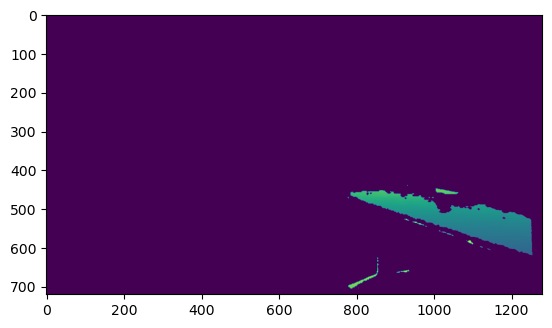

[DBSCAN] Found 3 clusters
[DBSCAN] Removing 49 noise points


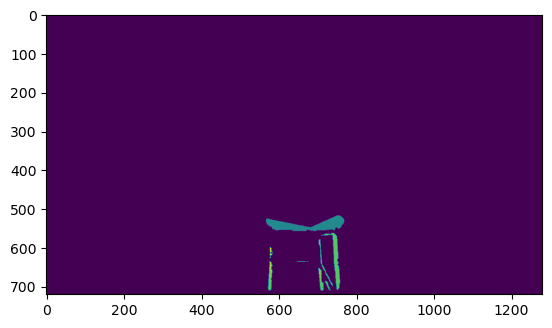

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 30 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.10103704418608726


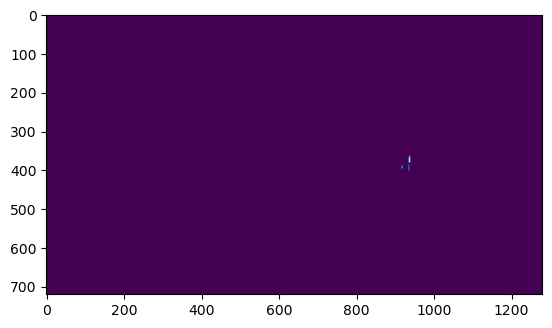

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 3 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


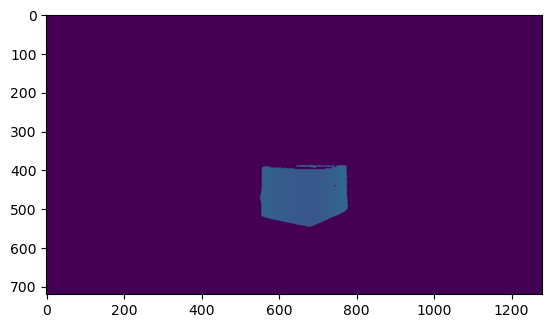

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 5 noise points


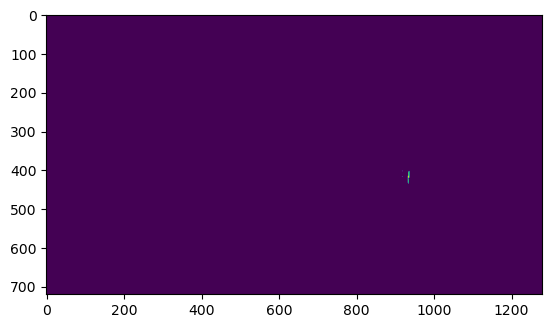

[DBSCAN] Found 0 clusters
[DBSCAN] Removing 6 noise points


/home/bwilab/Semantic-Mapping-BWI/aggregator.py:33: RuntimeWarning: Mean of empty slice.
  distance = np.asarray(distance).mean()
/home/bwilab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


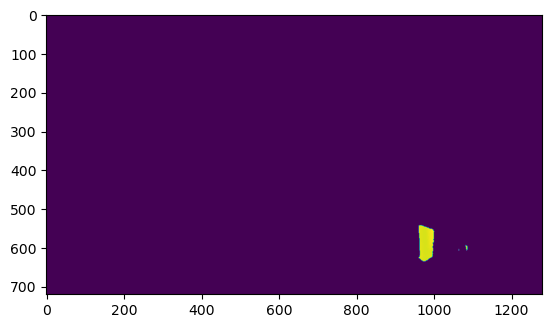

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 6 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


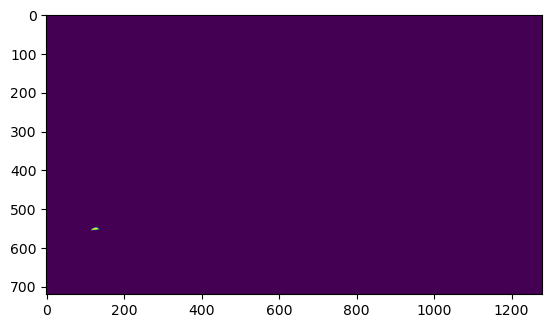

[DBSCAN] Found 0 clusters
[DBSCAN] Removing 9 noise points


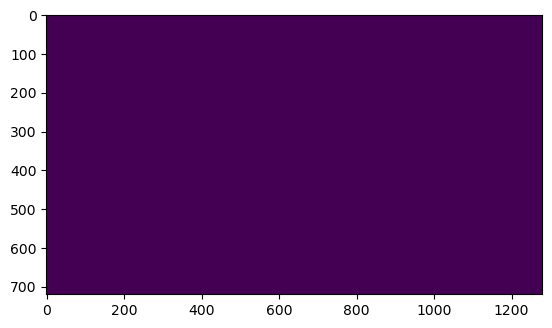

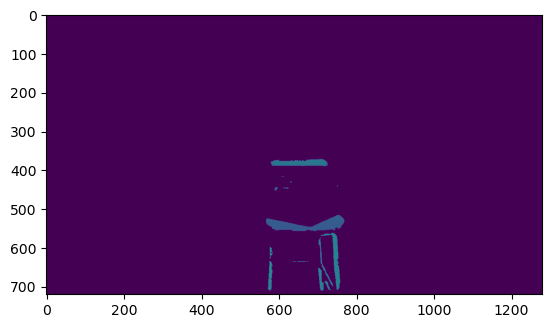

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 36 noise points


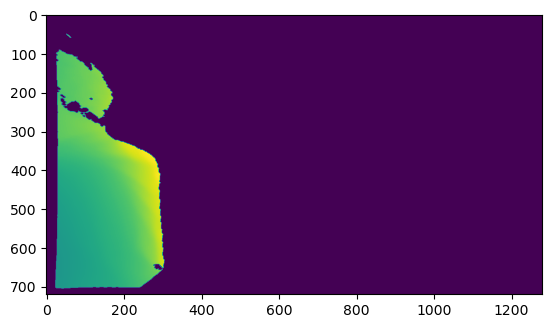

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 3 noise points


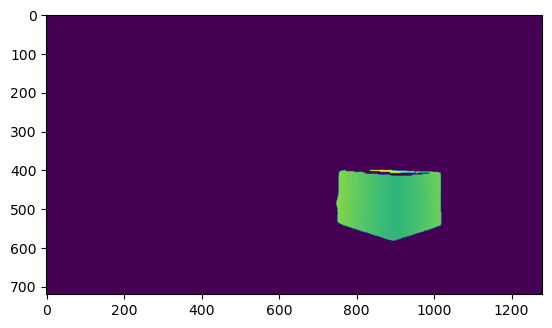

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


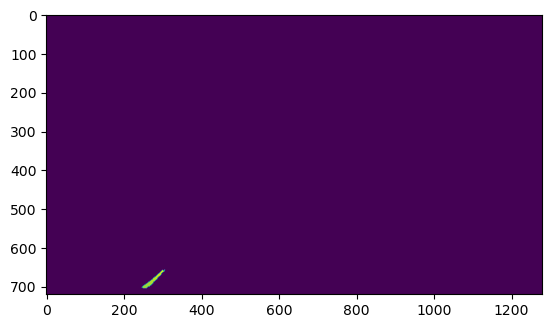

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.004558741719993723


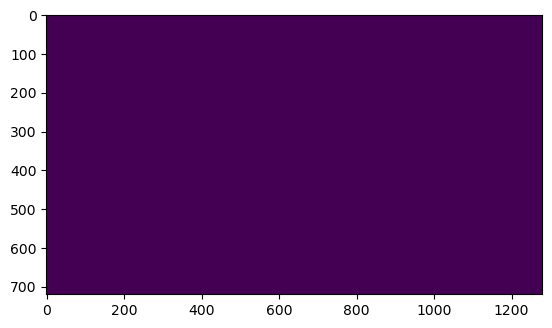

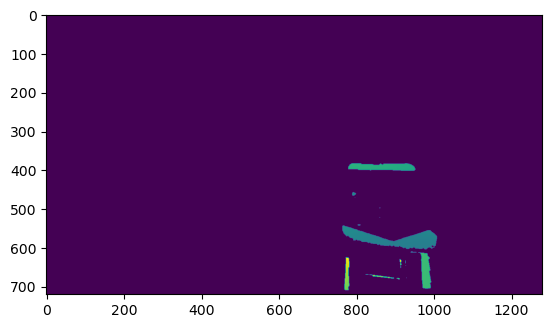

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 23 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


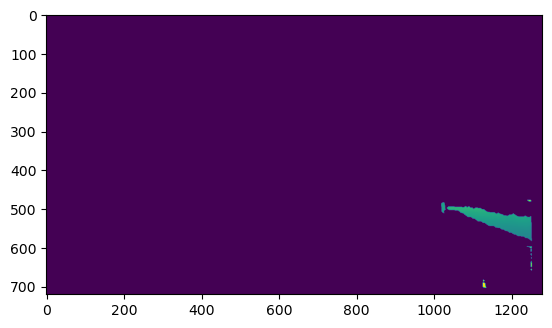

[DBSCAN] Found 3 clusters
[DBSCAN] Removing 13 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.06721918153830596


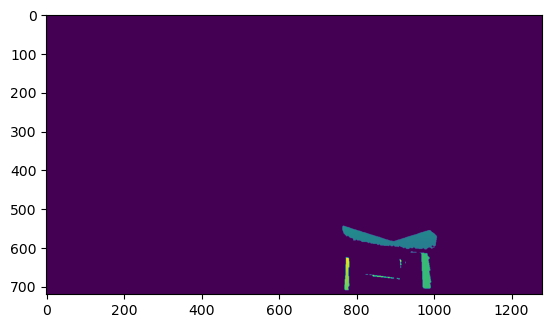

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 11 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.10789157431862843


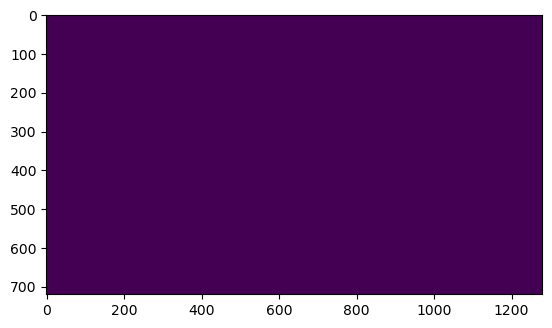

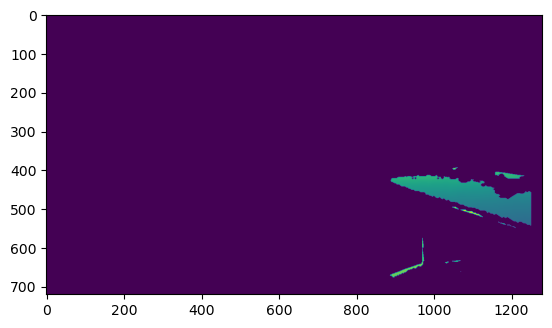

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 33 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.06388794456556222


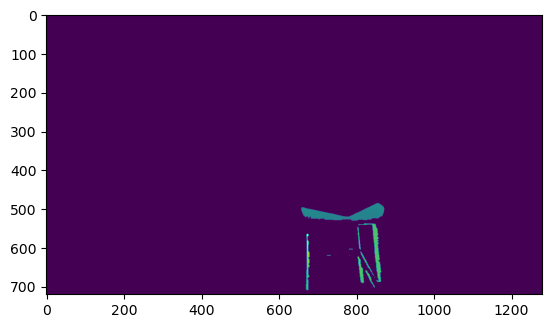

[DBSCAN] Found 3 clusters
[DBSCAN] Removing 25 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.09446903211285544


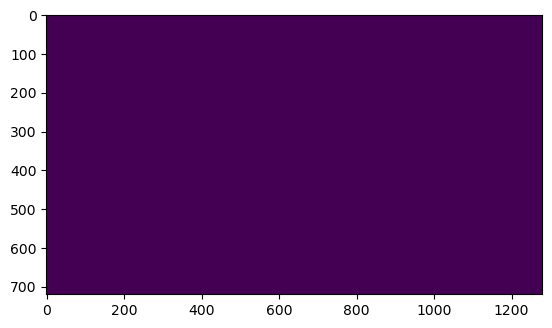

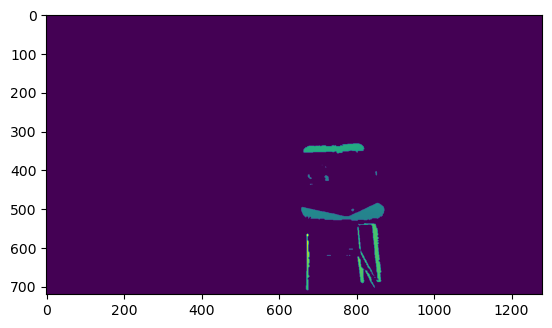

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 33 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


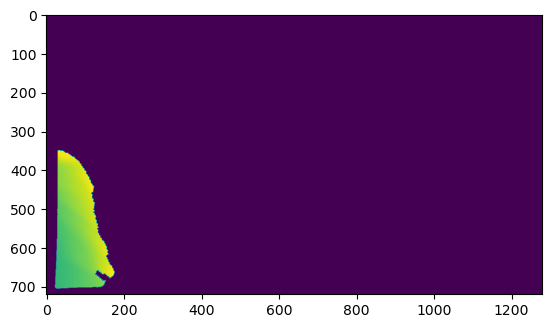

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.01332927029513235


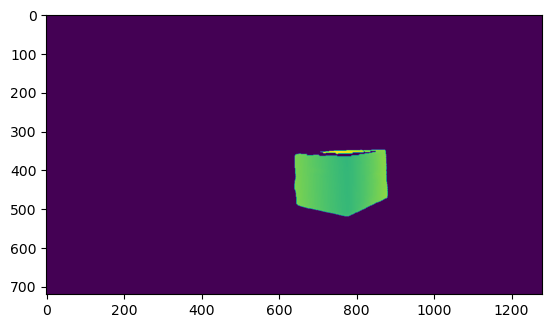

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.005358822500112125


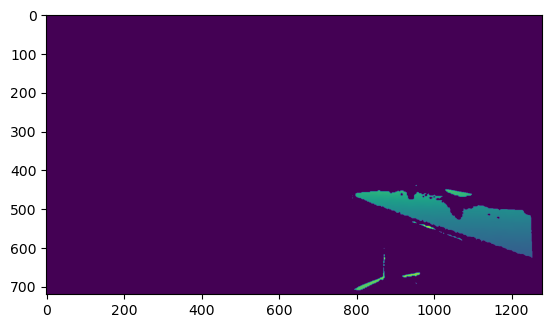

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 18 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.12597555083831363


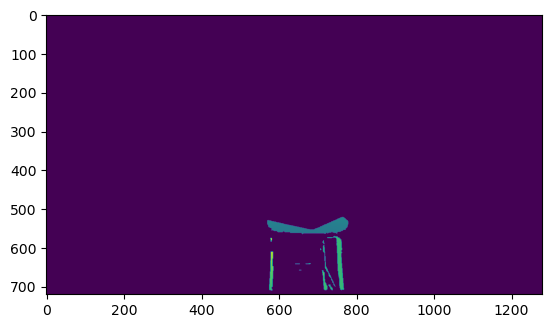

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 25 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.1363397777500561


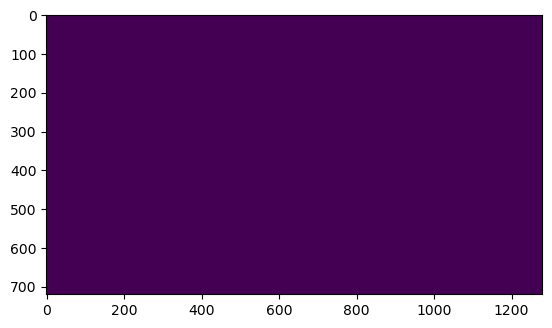

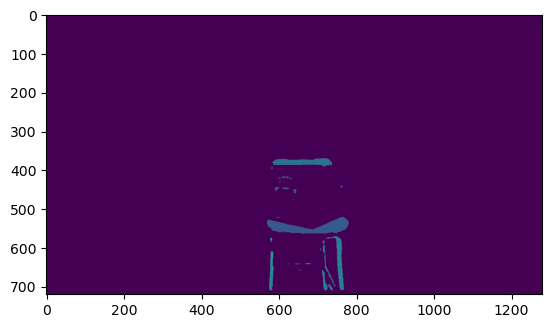

[DBSCAN] Found 7 clusters
[DBSCAN] Removing 23 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


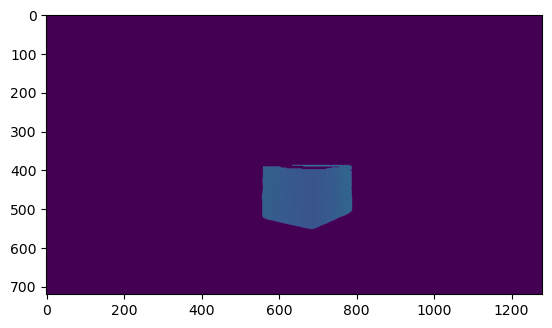

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 4 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


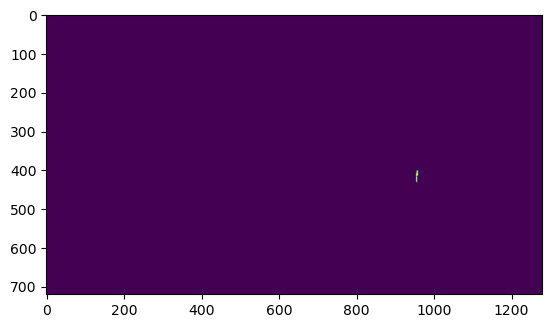

[DBSCAN] Found 0 clusters
[DBSCAN] Removing 10 noise points


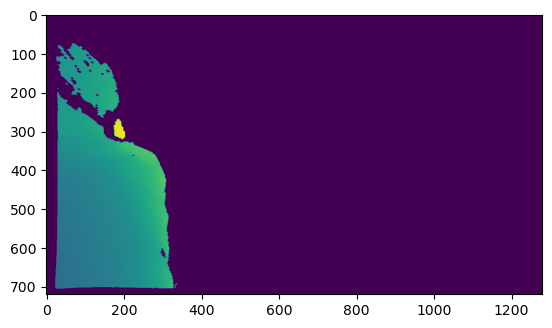

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.037083003671706465


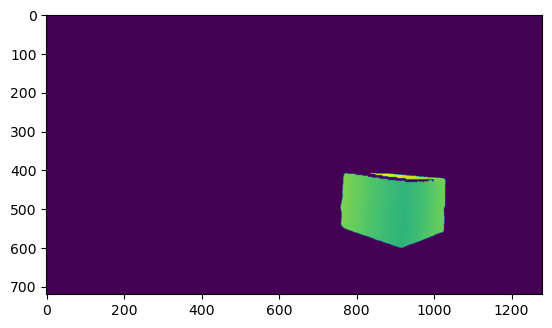

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


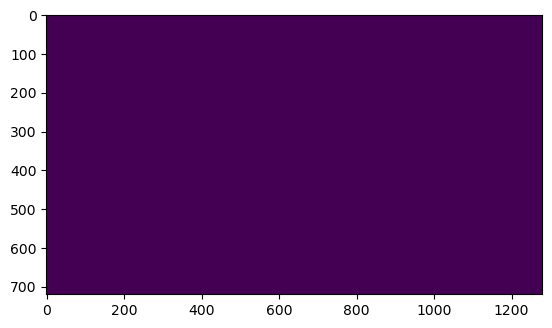

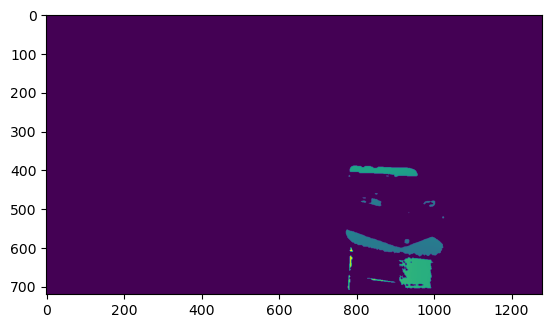

[DBSCAN] Found 7 clusters
[DBSCAN] Removing 37 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


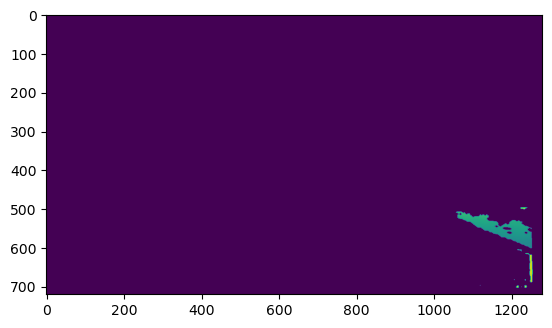

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 16 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


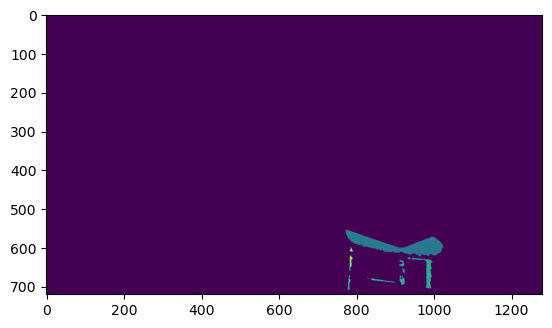

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 39 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.057902662680370164


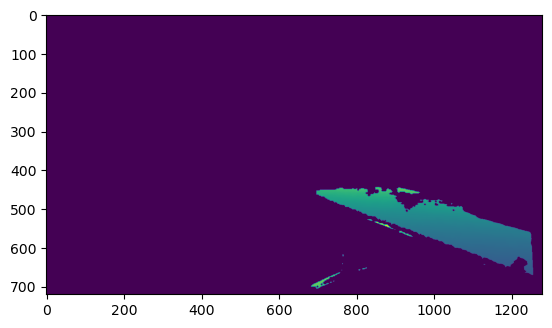

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 20 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.1048758797677971


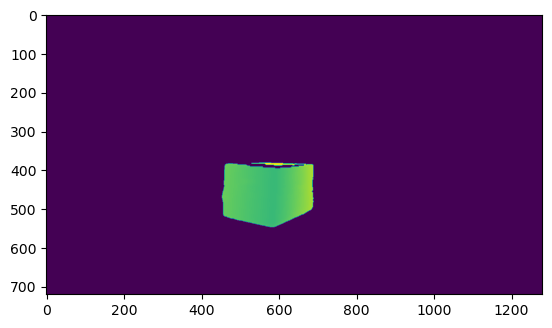

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


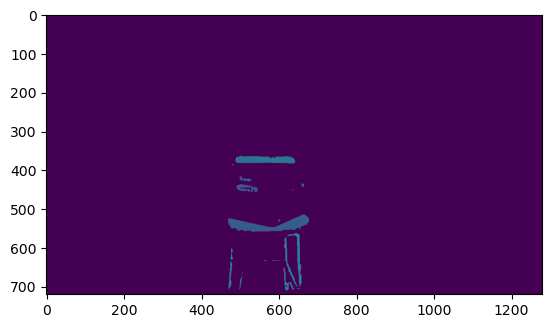

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 47 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


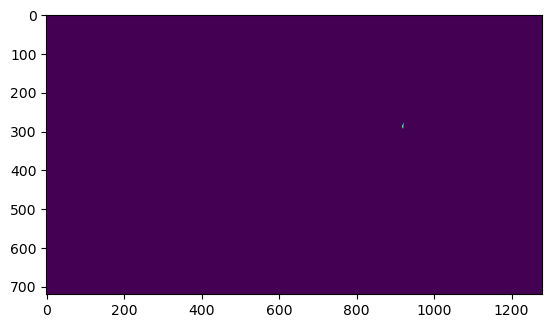

[DBSCAN] Found 0 clusters
[DBSCAN] Removing 3 noise points


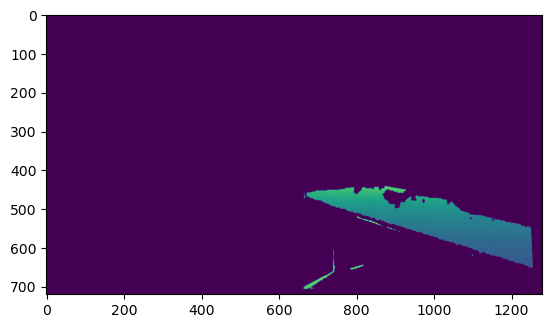

[DBSCAN] Found 3 clusters
[DBSCAN] Removing 36 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.03943252398105072


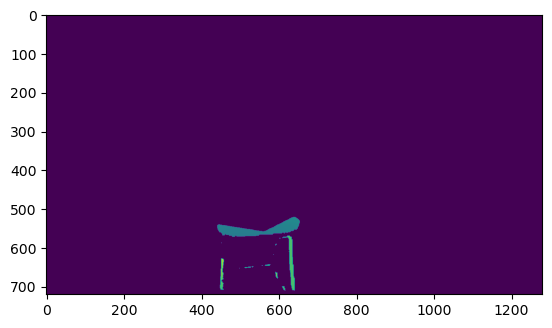

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 28 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.15545852757971226


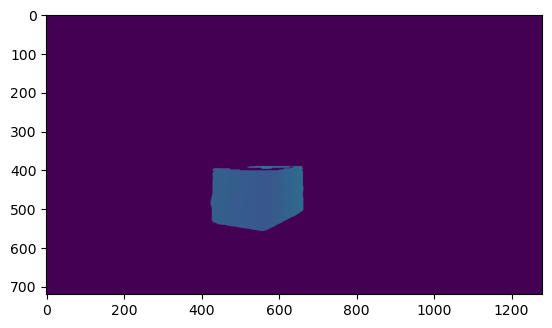

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 5 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


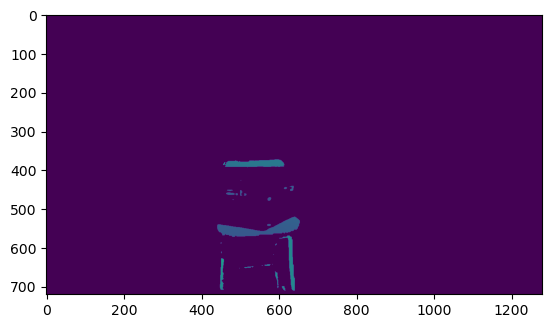

[DBSCAN] Found 7 clusters
[DBSCAN] Removing 47 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


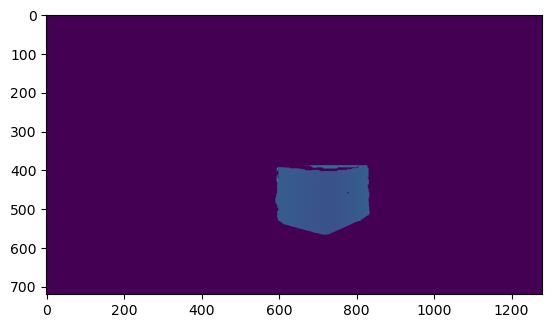

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 1 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


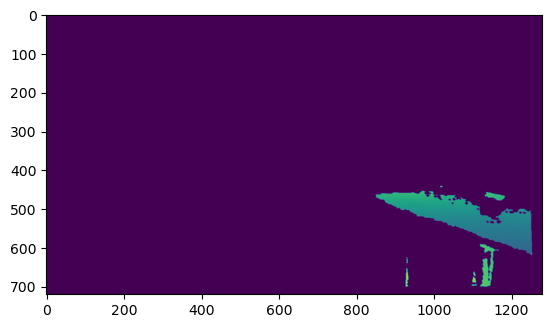

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 12 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


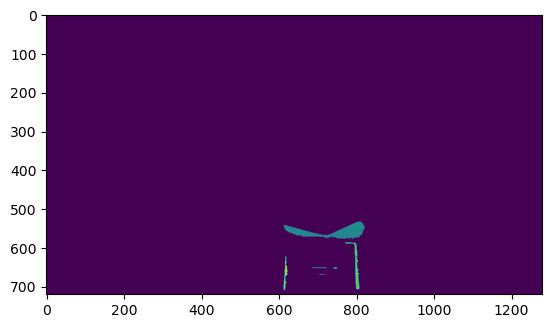

[DBSCAN] Found 3 clusters
[DBSCAN] Removing 14 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


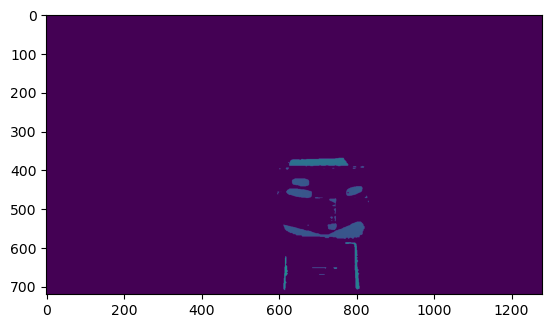

[DBSCAN] Found 6 clusters
[DBSCAN] Removing 29 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


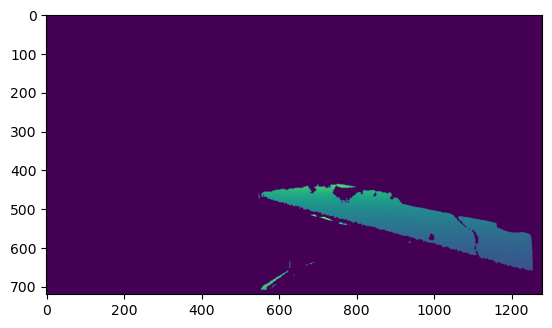

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 27 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.07793768744121563


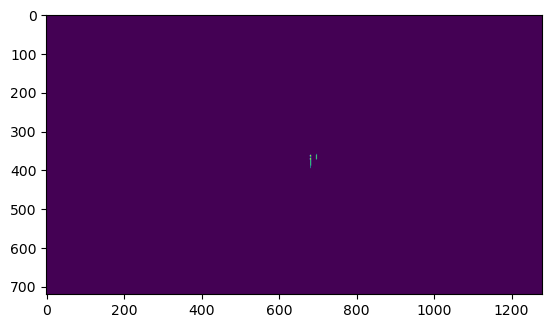

[DBSCAN] Found 0 clusters
[DBSCAN] Removing 2 noise points


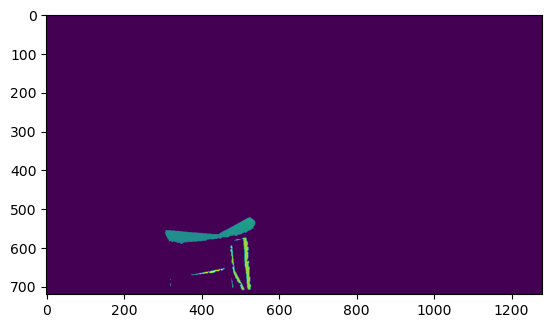

[DBSCAN] Found 3 clusters
[DBSCAN] Removing 7 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.08768065571252187


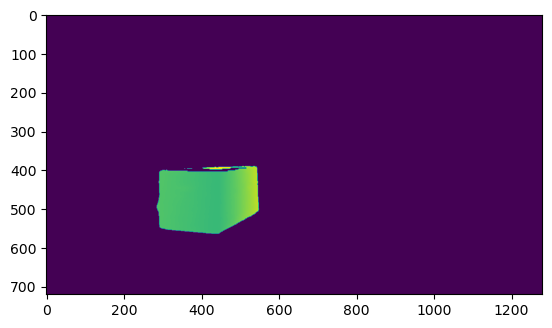

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 3 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


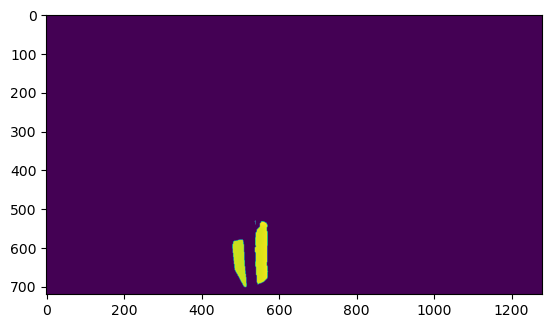

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 4 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


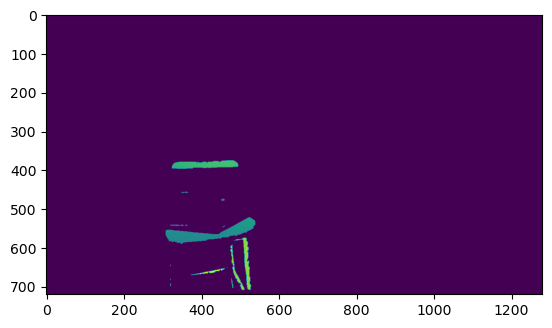

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 17 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


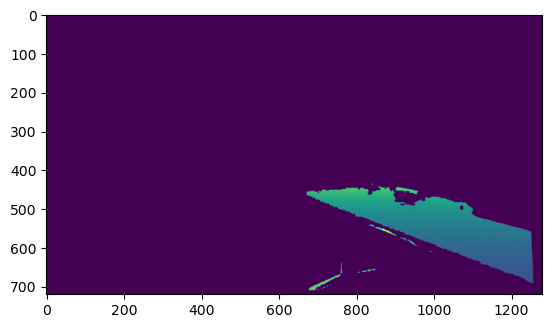

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 40 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.0481913439990931


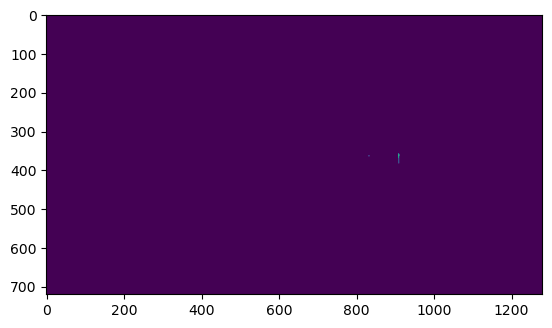

[DBSCAN] Found 0 clusters
[DBSCAN] Removing 4 noise points


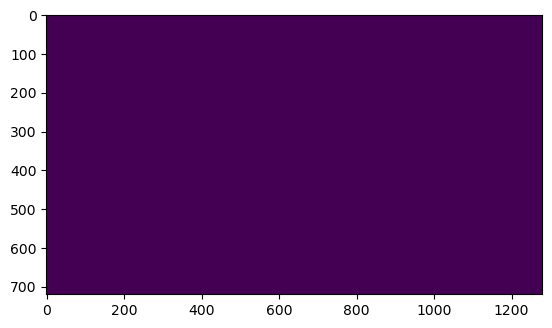

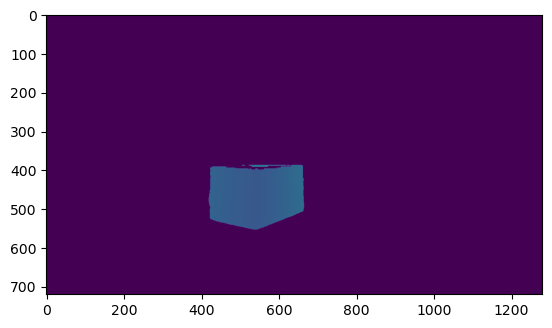

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


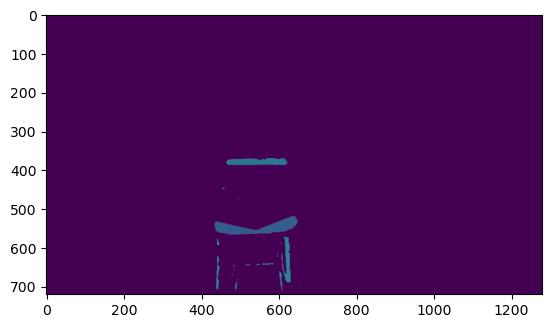

[DBSCAN] Found 6 clusters
[DBSCAN] Removing 38 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


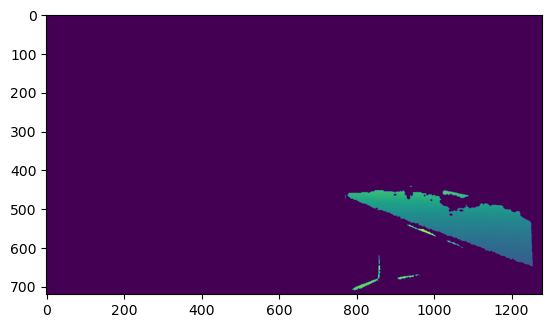

[DBSCAN] Found 6 clusters
[DBSCAN] Removing 19 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.048223756602165345


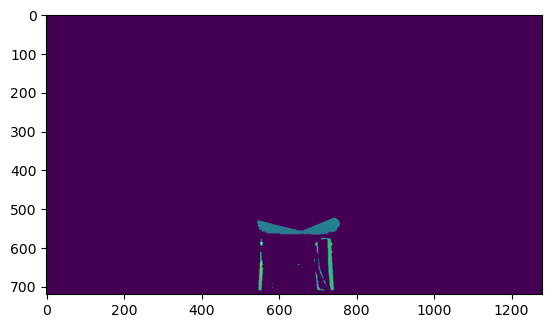

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 21 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.10134711754704394


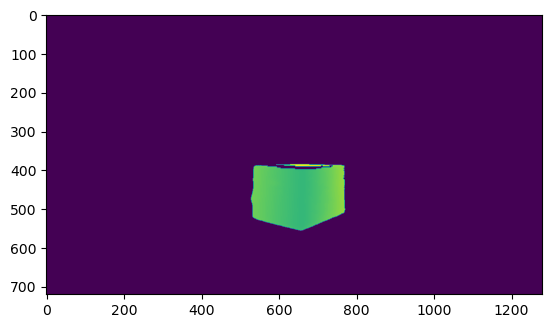

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 1 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


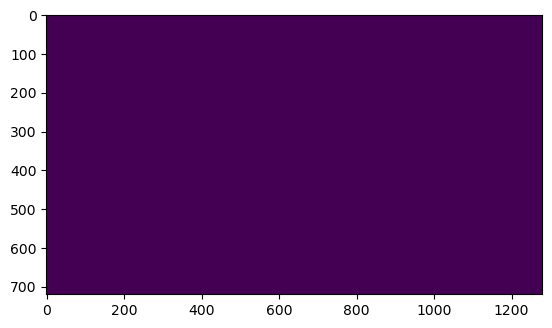

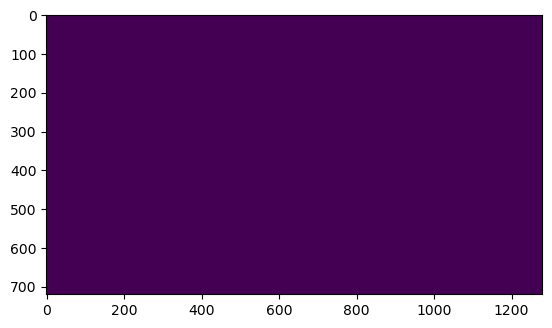

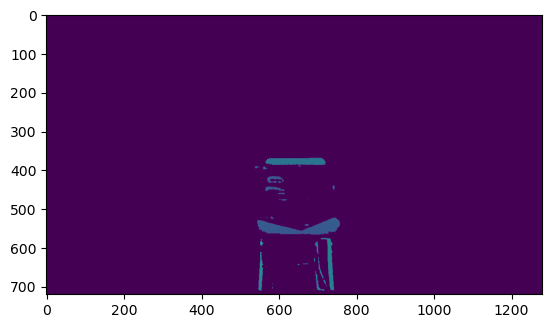

[DBSCAN] Found 7 clusters
[DBSCAN] Removing 40 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


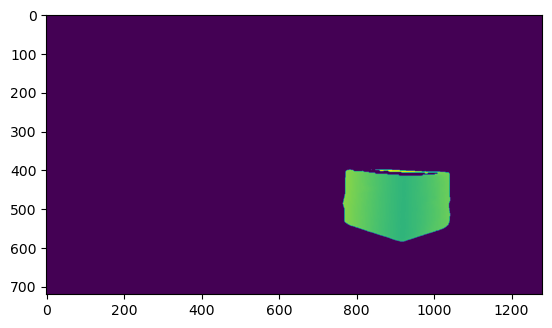

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


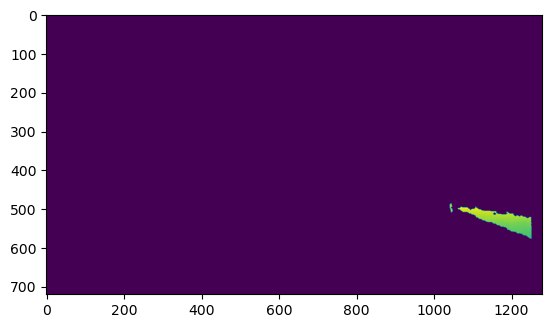

[DBSCAN] Found 2 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


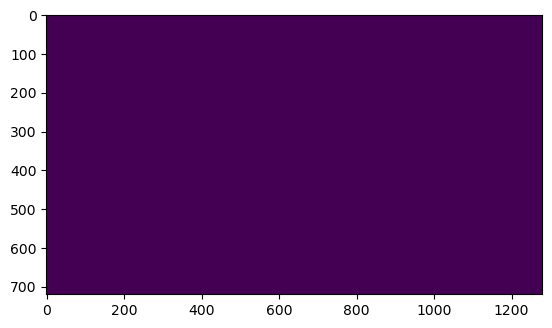

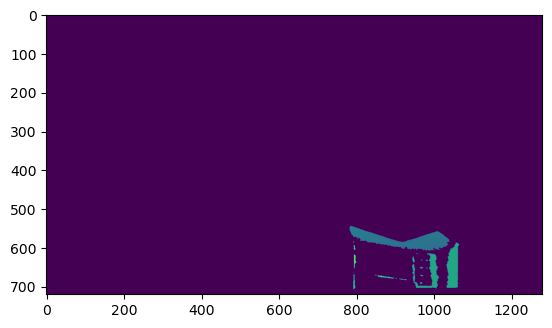

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 36 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.06917603480312925


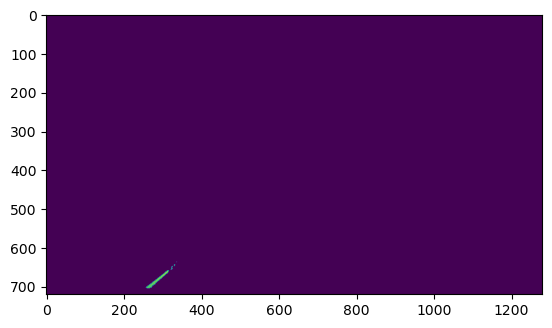

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 3 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.003514563232655568


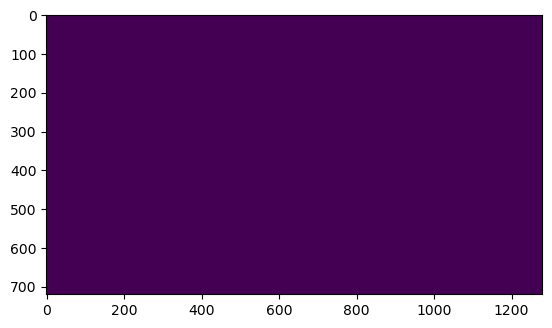

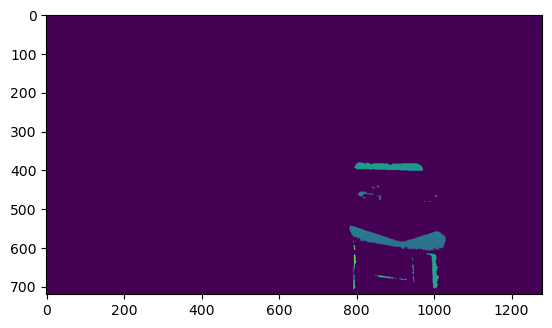

[DBSCAN] Found 5 clusters
[DBSCAN] Removing 48 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


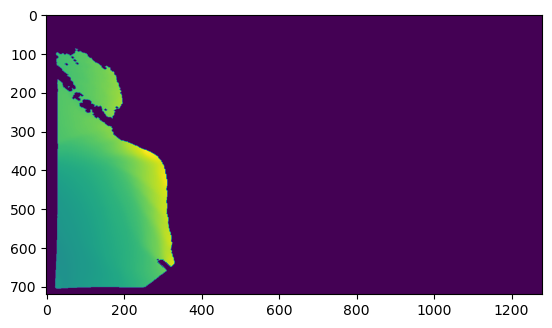

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.035768231807996445


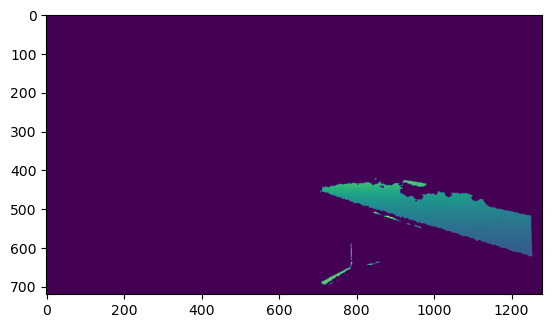

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 31 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.10663697629708735


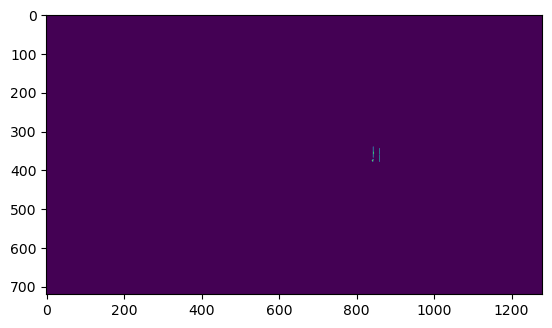

[DBSCAN] Found 0 clusters
[DBSCAN] Removing 2 noise points


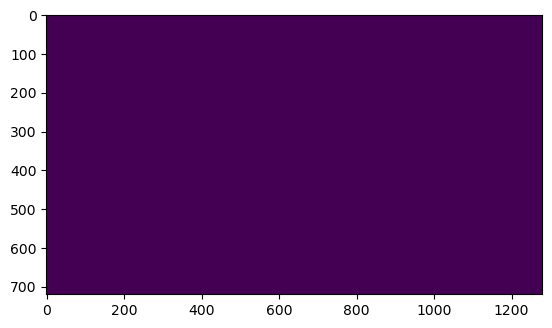

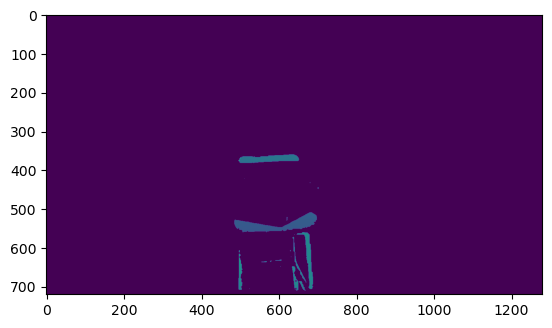

[DBSCAN] Found 4 clusters
[DBSCAN] Removing 21 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


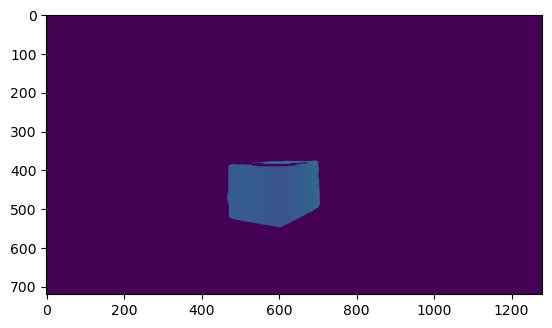

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 1 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


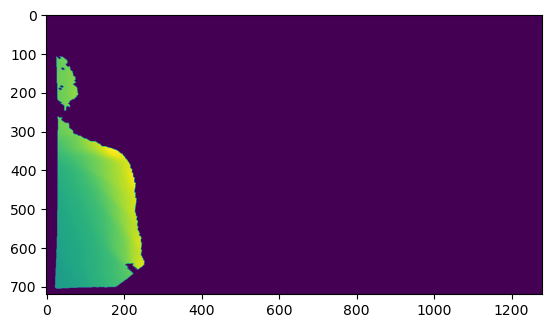

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.02463783170995028


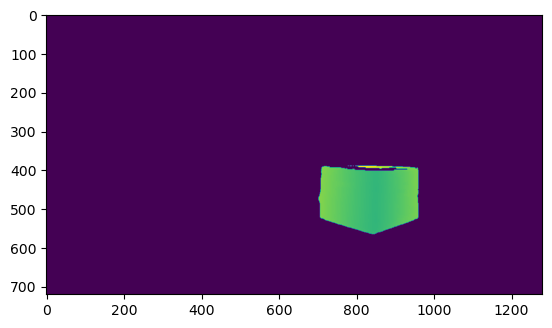

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


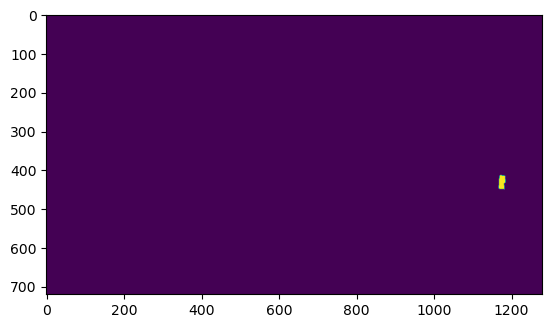

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 0.0	RMSE (lower is better): 0.0


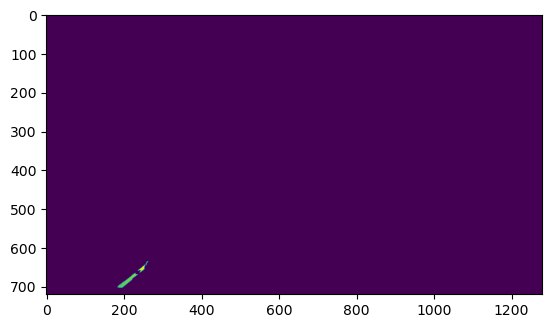

[DBSCAN] Found 1 clusters
[DBSCAN] Removing 0 noise points
[ICP] Fitness (higher is better): 1.0	RMSE (lower is better): 0.0039094959691262435


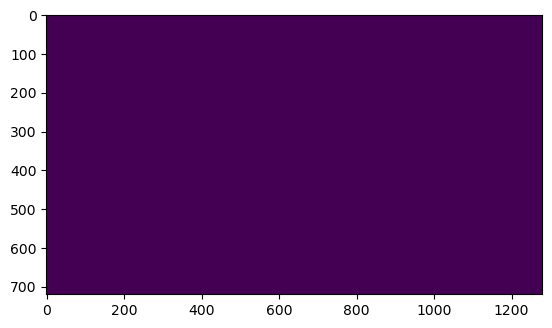

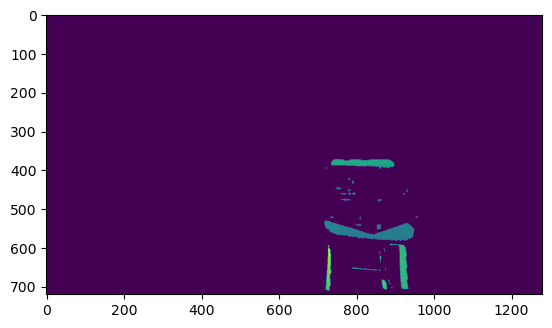

KeyboardInterrupt: 

In [8]:
## must have /rgb, /depth directories and /poses.txt file
FILEPATH = "/home/bwilab/Documents/RTAB-Map"
OBJECT_LABELS = "box. chair. table. person."

all_masks = defaultdict(list) # Object label --> list[masks]
pointclouds = defaultdict(list) # Object label --> list[PointCloud]
projector = PointProjector()
aggregator = PointCloudAggregator(eps=1.50) ## higher eps == more merging, lower eps == more detail (or noise)

extrinsics = get_rotation_translation(f"{FILEPATH}/poses.txt")
rgb_images = [f"{FILEPATH}/rgb/{file}" for file in os.listdir(f"{FILEPATH}/rgb")]
depth_images = [f"{FILEPATH}/depth/{file}" for file in os.listdir(f"{FILEPATH}/depth")]
assert(len(rgb_images) == len(depth_images) == len(extrinsics))

for rgb_path, depth_path, transform in zip(rgb_images, depth_images, extrinsics):
    scene = defaultdict(list) # Object label --> list[masks]

    with Image.open(rgb_path) as color_image, Image.open(depth_path) as depth_image:
        ## Make sure images are same dims
        color_image, depth_image = np.array(color_image), np.array(depth_image)
        resized_color_image = cv2.resize(color_image, depth_image.shape[::-1])

    ## Feed through DINO
    image_pil, image_tensor = prepare_image(resized_color_image)
    boxes, pred_phrases = get_grounding_output(
        gd_model, image_tensor, OBJECT_LABELS, BOX_THRESHOLD, TEXT_THRESHOLD, device=DEVICE
    )

    ## Prepare SAM
    sam_model.set_image(resized_color_image)
    W, H = image_pil.size
    for i in range(boxes.size(0)):
        boxes[i] *= torch.Tensor([W, H, W, H])
        boxes[i][:2] -= boxes[i][2:] / 2
        boxes[i][2:] += boxes[i][:2]

    ## SAM outputs
    transformed_boxes = sam_model.transform.apply_boxes_torch(boxes, resized_color_image.shape[:2]).to(DEVICE)
    masks, _, _ = sam_model.predict_torch(
        point_coords=None, point_labels=None, boxes=transformed_boxes.to(DEVICE), multimask_output=False
    )

    ## Associate outputs
        ## How to use
        # color_pixels = color_image * mask[:, :, None]
        # depth_pixels = depth_image * mask
    for mask, box, label in zip(masks, boxes, pred_phrases):
        mask = mask[0].cpu().numpy()
        x0, y0 = box[0], box[1]
        label = label[:label.index('(')] # remove confidence
        scene[label].append(mask)
        all_masks[label].append(mask)

    ## Generating pointclouds
    for obj in scene:
        for mask in scene[obj]:
            masked_depth_image = depth_image * mask

            masked_color_image = color_image * mask[:, :, None]
            plt.imshow(masked_color_image)
            plt.imshow(masked_depth_image)
            plt.show()

            pcl = projector.get_pointcloud(masked_depth_image, stride=3)
            if pcl.is_empty():
                continue

            pcl.label = obj
            pcl.clean()
            target = aggregator.nearest_pointcloud(pcl)
            aggregator.aggregate_pointcloud(pcl, target, transform)
            
            # pointclouds[obj].append(pcl)
            # projector.visualize(pcl)

    """
    issues:
        - transformations are off
        - need to project "good" starting frames first (frames that show a lot of the object not like chair handles)
        - not projecting background rn
    """

# allpoints = []

# for obj in pointclouds:
#     for pcl in pointclouds[obj]:
#         allpoints.append(pcl)

projector.visualize(aggregator.main)

## Show masked images
# pcl_mask = scene['box'][0]
# masked_color = resized_color_image * pcl_mask[:, :, None]
# masked_depths = depth_image * pcl_mask
# fig, axes = plt.subplots(1, 3, figsize=(10,5))
# axes[0].axis('off'); axes[1].axis('off'); axes[2].axis('off')
# axes[0].imshow(masked_color); axes[1].imshow(masked_depths); axes[2].imshow(resized_color_image)
# plt.show()

## Show pointclouds
# projector.visualize(pointclouds['chair'][0])


In [ ]:
print('objects', aggregator._scene.keys())
projector.visualize(aggregator._scene['box'])

objects dict_keys(['table', 'box', 'chair', 'person'])
